# Setup

In [11]:
from sklearn.datasets import load_wine
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import random

from lib.baseline import *
from lib.baycon import execute

from lib.CF_De.cfde import CF_Descent
from lib.cf_a.cfae import CF_Ascent
from lib.neighborSearch.cfnMarginal import neighborSearchMarginal as neighborSearch
from dataclasses import dataclass
from lib.eval.generator import run, returnNames
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

import pickle
import json
import pathlib
import os
import time

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
data_set = "breast_cancer"
cf_amount = 25
random_state = 42

match data_set:
    case "breast_cancer":
        X, true_y = load_breast_cancer(return_X_y=True)
        nc = 2
    case "blobs":
        nc = 3
        X, true_y = make_blobs(centers=nc, cluster_std=2, n_features=2, n_samples=250, random_state=random_state)

#X, true_y = load_wine(return_X_y=True)
# X, true_y = load_breast_cancer(return_X_y=True)
# X, true_y = make_blobs(centers=3, cluster_std=2, n_features=2, n_samples=250)

X = StandardScaler().fit_transform(X)


random.seed(random_state)

km = KMeans(n_clusters=nc, random_state=random_state)
y = km.fit_predict(X)
centers = km.cluster_centers_

@dataclass
class CounterfactualData:
    cf: np.array
    instance: np.array
    target: int
    instance_label: float


cfs = []
for i in range(cf_amount):
    index = random.randint(0, len(X)-1)
    label = y[index]

    foo = set(range(nc))
    foo.remove(label)
    target = random.choice(list(foo))

    cfs.append(CounterfactualData([], index, target, label))

In [13]:
def pickle_cfs(cf_obj):
    name = cf_obj['name']
    p = pathlib.Path(f'./testdata/cfs/{data_set}/{name}.pkl')
    p.parent.mkdir(parents=True, exist_ok=True)
    with open(p, 'wb') as f:
        pickle.dump(cf_obj, f, protocol=pickle.HIGHEST_PROTOCOL)

def pickle_res(res_obj, method_name):
    p = pathlib.Path(f'./testdata/eval/{data_set}/{method_name}.pkl')
    p.parent.mkdir(parents=True, exist_ok=True)
    with open(p, 'wb') as f:
        pickle.dump(res_obj, f, protocol=pickle.HIGHEST_PROTOCOL)

# Cross testing of methods

## Baseline (Baycon)

In [ ]:
from lib.baseline import baseline_explainer
from lib.baycon import baycon_explainer
from sklearn.ensemble import RandomForestClassifier

explainer = baycon_explainer
baseline_cfs = []
runtimes = []
for cf in cfs:
    s = time.time()
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, cf.instance, target_cluster=int(cf.target))
    runtimes.append(time.time() - s)
    baseline_cfs.append(CounterfactualData(baseline_cf, cf.instance, cf.target, cf.instance_label))

baseLine = {
    "name": "Baseline (BayCon)",
    "counterfactuals": baseline_cfs
}
pickle_cfs(baseLine)

res, _ = run(baseLine, centers, X, y, runtimes)
pickle_res(res, baseLine['name'])

Done training classifier. Score: 1.0
--- Executing... Initial Instance: 114 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (780) CFs (0)
Re-training surrogate model with data size: 780
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (11) Unique overall (11)
Generated random instances: (3717)
Predicted top: 20 Counterfactuals: 1
Found new best [ 1.75697089  1.17803585  0.71360045  0.61758039  1.32650383  0.15923033
  1.73336055 -0.76554336 -0.59371141  1.35105038 -0.86141758 -1.14385933
  0.4680059   0.66637898 -0.68648583  0.91282138  0.02308669  0.92718396
  0.36564497 -0.02435258 -1.37527439 -0.98638119  1.82386314 -1.0480379
  1.75481236 -0.40763909  1.68839533 -1.2627      1.28320093  0.98386255], with fitness score 0.2846 (X 0.77612 Y 1.0 F 0.36667), oversampling
Known alternatives: 800
Best instance score 0.2846 (X 0.776

## Baseline (DICE)

In [16]:
from lib.baseline import baseline_explainer
from lib.dice import dice_explainer
from sklearn.ensemble import RandomForestClassifier

explainer = dice_explainer(10)
baseline_cfs = []
runtimes = []
for cf in cfs:
    s = time.time()
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, cf.instance, target_cluster=int(cf.target))
    runtimes.append(time.time() - s)
    baseline_cfs.append(CounterfactualData(baseline_cf, cf.instance, cf.target, cf.instance_label))

baseLine = {
    "name": "Baseline (DiCE)",
    "counterfactuals": baseline_cfs
}
pickle_cfs(baseLine)

res, _ = run(baseLine, centers, X, y, runtimes)
pickle_res(res, baseLine['name'])

Done training classifier. Score: 1.0


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Found 10 counterfactuals
Done training classifier. Score: 1.0


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Found 10 counterfactuals
Done training classifier. Score: 1.0


100%|██████████| 1/1 [01:11<00:00, 71.63s/it]


Found 10 counterfactuals
Done training classifier. Score: 1.0


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Found 10 counterfactuals
Done training classifier. Score: 1.0


100%|██████████| 1/1 [01:14<00:00, 74.34s/it]


Found 10 counterfactuals
Done training classifier. Score: 1.0


  0%|          | 0/1 [02:33<?, ?it/s]


KeyboardInterrupt: 

## Baycon - Model Agnostic

In [5]:
from lib.ext.baycon.common.Target import Target
baycon_cfs = []
modes = ['kmeans', 'model_agnostic']
run_mode = modes[1]
runtimes = []

pred = km.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

baycon_cfs = []
for cf in cfs:
    point_idx = cf.instance
    point_pred = int(km.predict([X[point_idx]])[0])
    if run_mode == modes[0]:
        t = Target(target_type="clustering_kmeans", target_feature="label", target_value=int(cf.target))
    elif run_mode == modes[1]:
        t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))

    s = time.time()
    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, km, t, point_idx)
    runtimes.append(time.time() - s)
    baycon_cfs.append(CounterfactualData(baycon_cf, cf.instance, cf.target, cf.instance_label))

Baycon = {
    "name": "Baycon - Model Agnostic",
    "counterfactuals": baycon_cfs
}

pickle_cfs(Baycon)

res, _ = run(Baycon, centers, X, y, runtimes)
print(res)
pickle_res(res, Baycon['name'])

--- Executing... Initial Instance: 114 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (773) CFs (728)
Re-training surrogate model with data size: 773
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (143) Unique overall (143)
Generated random instances: (3728)
Predicted top: 20 Counterfactuals: 20
Found new best [ 0.06274896 -0.80508343  1.24104426 -1.20586852  1.32650383  1.11461231
 -0.59610144  1.82802799 -0.59371141  1.91835712 -0.86141758 -1.14385933
 -0.7485156  -0.69021737  0.40669019 -0.18712594  0.02308669 -0.22646693
 -0.41920995  0.36528867 -1.37527439 -0.98638119 -1.27427429 -1.0480379
  0.43370267 -0.11364664 -0.12755887 -0.14627009  0.04083972  0.98386255], with fitness score 0.3011 (X 0.91796 Y 0.41 F 0.8), oversampling
Known alternatives: 793
Best instance score 0.3011 (X 0.91796 Y 0.41 F 0.8), found on epoch: 1

## Baycon - Kmeans

In [6]:
from lib.ext.baycon.common.Target import Target
baycon_cfs = []
modes = ['kmeans', 'model_agnostic']
run_mode = modes[0]
runtimes = []

pred = km.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

baycon_cfs = []
for cf in cfs:
    point_idx = cf.instance
    point_pred = int(km.predict([X[point_idx]])[0])
    if run_mode == modes[0]:
        t = Target(target_type="clustering_kmeans", target_feature="label", target_value=int(cf.target))
    elif run_mode == modes[1]:
        t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))

    s = time.time()
    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, km, t, point_idx)
    runtimes.append(time.time() - s)
    baycon_cfs.append(CounterfactualData(baycon_cf, cf.instance, cf.target, cf.instance_label))

Baycon = {
    "name": "Baycon - KMeans",
    "counterfactuals": baycon_cfs
}

pickle_cfs(Baycon)

res, _ = run(Baycon, centers, X, y, runtimes)
print(res)
pickle_res(res, Baycon['name'])

--- Executing... Initial Instance: 114 Target: 0 Run: 0 ---
[0.98649786 0.49202131 1.01866689 0.97479724 0.5871176  1.014073
 1.14492245 1.17028266 0.60339021 0.22927434 0.86311672 0.04416341
 0.86446528 0.8137762  0.01228944 0.69281919 0.63976499 0.77166695
 0.13798752 0.40384985 1.05221312 0.51705679 1.07769473 1.01391704
 0.59804381 0.95285513 1.05144274 1.15328841 0.5994129  0.61362004]
2.0251859532156713
18.549947321332983
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (776) CFs (776)
Re-training surrogate model with data size: 776
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (26) Unique overall (26)
Generated random instances: (3731)
Predicted top: 20 Counterfactuals: 20
Found new best [-1.53404353 -0.80508343  0.27923496 -1.20586852  1.32650383 -0.42320519
 -0.59610144 -0.76554336 -0.59371141  1.91835712 -0.86141758 -1.14385933
 -0.74851

## CFDE

In [7]:
cfde_cfs = []
amount = 20
runtimes = []
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        s = time.time()
        x1, cf1, h1 = CF_Descent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20)
        runtimes.append(time.time() - s)
        temp_cfs.append(cf1)
    cfde_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))    

cfde = {
    "name": "CFDE",
    "counterfactuals": cfde_cfs
}

pickle_cfs(cfde)

res, _ = run(cfde, centers, X, y, runtimes)
pickle_res(res, cfde['name'])

Starting on: CFDE
Removing invalid counterfactuals!!!


## CFAE

In [8]:
cfae_cfs = []
amount = 20
runtimes = []
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        s = time.time()
        x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20, center_mode=False)
        runtimes.append(time.time() - s)
        temp_cfs.append(cf2)
    cfae_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))

cfae = {
    "name": "CFAE",
    "counterfactuals": cfae_cfs
}

pickle_cfs(cfae)

res, _ = run(cfae, centers, X, y, runtimes)
pickle_res(res, cfae['name'])

Starting on: CFAE
Removing invalid counterfactuals!!!


## NeighborSearch

In [9]:
ns_cfs = []
runtimes = []
for cf in cfs:
    s = time.time()
    i, new_cfs = neighborSearch(X=X, y=y, target=cf.target, model=km, instance_index=cf.instance, n=15)
    runtimes.append(time.time() - s)
    ns_cfs.append(CounterfactualData(new_cfs, cf.instance, cf.target, cf.instance_label))

nfs = {
    "name": "NeighborSearch",
    "counterfactuals": ns_cfs
}

pickle_cfs(nfs)

res, _ = run(nfs, centers, X, y,runtimes)
pickle_res(res, nfs['name'])

Starting on: NeighborSearch
Removing invalid counterfactuals!!!


## Dice Mod

In [10]:
from lib.dice_mod import Gainer, gradient_ascent, adam_opt, random_opt
from scipy.spatial.distance import pdist
from lib.util import sparsity_fix


def runner(eps):
    dice_cfs = []
    runtimes = []
    for cf in cfs:
        instance = X[cf.instance].reshape(1, -1)
        s = time.time()
        gainer = Gainer(centers, X, cf.target, instance, eps=eps)
        dice_cf = np.array([adam_opt(instance, gainer.gain, max_iter=1000, lr=1)[0][0]])
        runtimes.append(time.time() - s)
        # print(dice_cf.shape)
        # print([km.predict(cf.reshape(1,-1)) for cf in dice_cf])
        dice_cfs.append(CounterfactualData(dice_cf, cf.instance, cf.target, cf.instance_label))

    # centers = km.cluster_centers_
    # dists = np.linalg.norm(dice_cf.reshape(1, -1) - centers, axis=1)
    # print(dists)

    name = f'dice_mod (eps={eps})'

    dice_mod = {
        "name": name,
        "counterfactuals": dice_cfs
    }

    pickle_cfs(dice_mod)

    res, _ = run(dice_mod, centers, X, y, runtimes)
    pickle_res(res, dice_mod['name'])

    runtimes_fix = []
    dice_cfs_fixed =  []
    for i,cf in enumerate(dice_cfs):
        s = time.time()
        fixed = sparsity_fix(cf.cf, X[cf.instance, :].reshape(1, -1), km)
        runtimes_fix.append(runtimes[i] + (time.time() - s))
        new_cf = CounterfactualData(
            fixed, 
            cf.instance, cf.target, cf.instance_label
        )
        dice_cfs_fixed.append(new_cf)

    dice_mod_sparsity_fix = {
        "name": f"dice_mod_sparsity_fix (eps={eps})",
        "counterfactuals": dice_cfs_fixed
    }

    pickle_cfs(dice_mod_sparsity_fix)

    res, _ = run(dice_mod_sparsity_fix, centers, X, y, runtimes_fix)
    pickle_res(res, dice_mod_sparsity_fix['name'])

for eps in [0, 0.1, 0.25, 0.5, 0.75, 1]:
    runner(eps)

X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 110, score: 0.8499335234278281
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 112, score: 0.8611025893181288
Starting on: dice_mod (eps=0)
Removing invalid counterfactuals!!!
Original counterfactual: [[ 9.74676977e-01 -2.31911162e-01  9.86041729e-01  5.93292280e-01
   3.83011652e-01  2.13809776e-01  2.90726243e-01  3.74388768e-01
   4.72675083e-04  1.04964333e+00  1.44199799e-01 -5.62171675e-01
   1.02558036e-01  3.88193232e-02 -2.74541672e-01  7.64683156e-01
   9.45570082e-01  6.12900042e-01  2.79335688e-01  6.92113169e-01
   9.05913352e-01 -3.02125557e-01  8.52953763e-01  5.09634255e-01
   1.12381660e+00  6.40893250e-01  4.83179230e-01  3.95977701e-01
   7.25980815e-01  3.18987659e-01]]
instance: [[-1.53404353 -0.80508343 -1.48816212 -1.20586852  1.32650383 -0.42320519
  -0.59610144 -0.76554336 -0.59371141  1.91835712 -0.86141758 -1.14385933
  -0.7485156  -0.69021737  0.40669019 -0.18712594  0.02308669 -0.22646693
  -0.41920995  0.00419713 -1.375274

## Dice Mod - Random

In [11]:
from lib.dice_mod import Gainer, gradient_ascent, adam_opt, random_opt
from scipy.spatial.distance import pdist
import torch

dice_cfs = []
count = 10
runtimes = []
torch.manual_seed(42)

for cf in cfs:
    instance = X[cf.instance].reshape(1, -1)
    s = time.time()
    gainer = Gainer(centers, X, cf.target, instance, eps=0)
    dice_cf = np.array([random_opt(instance, gainer.gain)[0][0]  for _ in range(count)])
    runtimes.append(time.time() - s)
    print(dice_cf.shape)
    print([km.predict(cf.reshape(1,-1)) for cf in dice_cf])
    dice_cfs.append(CounterfactualData(dice_cf, cf.instance, cf.target, cf.instance_label))

# centers = km.cluster_centers_
# dists = np.linalg.norm(dice_cf.reshape(1, -1) - centers, axis=1)
# print(dists)

dice_mod = {
    "name": "dice_mod_random",
    "counterfactuals": dice_cfs
}

pickle_cfs(dice_mod)

res, _ = run(dice_mod, centers, X, y, runtimes)
pickle_res(res, dice_mod['name'])

X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 158, score: 0.38836097362743666
iter: 170, score: 0.8422174023427769
iter: 169, score: 0.8389909828037
iter: 164, score: 0.34332993273121276
iter: 142, score: 0.29809490774811453
iter: 164, score: 0.4117129350041305
iter: 153, score: 0.8427608786606812
iter: 161, score: 0.3772843409351361
iter: 160, score: 0.3846758671831146
iter: 160, score: 0.359275385881189
(10, 30)
[array([0], dtype=int32), array([0], dtype=int32), array([0], dtype=int32), array([0], dtype=int32), array([1], dtype=int32), array([0], dtype=int32), array([0], dtype=int32), array([0], dtype=int32), array([0], dtype=int32), array([0], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 168, score: 0.8638494404523932
iter: 161, score: 0.374928098824354
iter: 160, score: 0.8618315495630952
iter: 156, score: 0.7077493119923696
iter: 169, score: 0.8634632668602215
iter: 166, score: 0.8612864373485751
iter: 158, score: 0.428169033365147
iter: 154, score: 0.378657644870411
iter: 17

## threshold tree / imm

In [12]:
from lib.threshold_tree import ThresholdTree

tt_dtc_cfs = []
runtimes_dtc = []

tt_dtc_prime_cfs = []
runtimes_prime_dtc = []

tt_imm_cfs = []
runtimes_imm = []

tt_imm_prime_cfs = []
runtimes_prime_imm = []

tt_rf_cfs = []
runtimes_rf = []

tt_dtc_tree_cfs = []
runtimes_dtc_tree = []

tt_prime_dtc_tree_cfs = []
runtimes_prime_dtc_tree = []

tt = ThresholdTree(km, centers, X, y)
s = time.time()
tt.fit_dtc(False)
dtc_train_time = time.time() - s
print(f"dtc train time: {dtc_train_time}")
for cf in cfs:
    s = time.time()
    tt_cf = tt.find_counterfactuals_dtc(X[cf.instance], cf.target, False)
    runtimes_dtc.append(time.time() - s)
    cf_data = CounterfactualData(tt_cf, cf.instance, cf.target, cf.instance_label)
    tt_dtc_cfs.append(cf_data)
runtimes_dtc[0] += dtc_train_time


for i, cf in enumerate(cfs):
    s = time.time()
    tt_cf_prime = tt.plausibility_fix(tt_cf, X[cf.instance], cf.target, "DTC")
    runtimes_prime_dtc.append(runtimes_dtc[i] + time.time() - s)
    cf_data = CounterfactualData(tt_cf_prime, cf.instance, cf.target, cf.instance_label)
    tt_dtc_prime_cfs.append(cf_data)
runtimes_prime_dtc[0] += dtc_train_time

tt = ThresholdTree(km, centers, X, y)
s = time.time()
tt.fit_dtc(True)
dtc_train_time = time.time() - s
print(f"dtc (FIDELITY) train time: {dtc_train_time}")
for cf in cfs:
    s = time.time()
    tree_cfs = tt.find_counterfactuals_dtc(X[cf.instance], cf.target, True)
    runtimes_dtc_tree.append(time.time() - s)
    cf_data = CounterfactualData(tree_cfs, cf.instance, cf.target, cf.instance_label)
    tt_dtc_tree_cfs.append(cf_data)
runtimes_dtc_tree[0] += dtc_train_time

for i, cf in enumerate(cfs):
    s = time.time()
    tree_cfs_prime = tt.plausibility_fix(tree_cfs, X[cf.instance], cf.target, "DTC")
    runtimes_prime_dtc_tree.append(runtimes_dtc_tree[i] + time.time() - s)
    cf_data = CounterfactualData(tree_cfs_prime, cf.instance, cf.target, cf.instance_label)
    tt_prime_dtc_tree_cfs.append(cf_data)
runtimes_prime_dtc_tree[0] += dtc_train_time

tt = ThresholdTree(km, centers, X, y)
s = time.time()
tt.fit_imm()
imm_train_time = time.time() - s
print(f"IMM train time: {imm_train_time}")
for cf in cfs:
    s = time.time()
    tt_imm_cf = tt.find_counterfactuals_imm(X[cf.instance], cf.target)
    runtimes_imm.append(time.time() - s)
    cf_data = CounterfactualData(tt_imm_cf, cf.instance, cf.target, cf.instance_label)
    tt_imm_cfs.append(cf_data)
runtimes_imm[0] += imm_train_time

for i, cf in enumerate(cfs):
    s = time.time()
    tt_imm_cf_prime = tt.plausibility_fix(tt_imm_cf, X[cf.instance], cf.target, "IMM")
    runtimes_prime_imm.append(runtimes_imm[i] + time.time() - s)
    tt_imm_prime_cfs.append(cf_data)
    cf_data = CounterfactualData(tt_imm_cf_prime, cf.instance, cf.target, cf.instance_label)
runtimes_prime_imm[0] += imm_train_time

tt_dtc_tree = {
    "name": "ThresholdTree_fidelity_Tree_Fix",
    "counterfactuals": tt_dtc_tree_cfs
}
pickle_cfs(tt_dtc_tree)

res, _ = run(tt_dtc_tree, centers, X, y, runtimes_dtc_tree)
pickle_res(res, tt_dtc_tree['name'])

tt_prime_dtc_tree = {
    "name": "ThresholdTree_DTC_fidelity_Post_Proccesing",
    "counterfactuals": tt_prime_dtc_tree_cfs
}
pickle_cfs(tt_prime_dtc_tree)

res, _ = run(tt_prime_dtc_tree, centers, X, y, runtimes_prime_dtc_tree)
pickle_res(res, tt_prime_dtc_tree['name'])

tt_dtc = {
    "name": "ThresholdTree_DTC",
    "counterfactuals": tt_dtc_cfs
}
pickle_cfs(tt_dtc)

res, _ = run(tt_dtc, centers, X, y, runtimes_dtc)
pickle_res(res, tt_dtc['name'])

tt_dtc_prime = {
    "name": "ThresholdTree_DTC_Post_Proccesing",
    "counterfactuals": tt_dtc_prime_cfs
}
pickle_cfs(tt_dtc_prime)

res, _ = run(tt_dtc_prime, centers, X, y, runtimes_prime_dtc)
pickle_res(res, tt_dtc_prime['name'])


tt_imm = {
    "name": "ThresholdTree_IMM",
    "counterfactuals": tt_imm_cfs
}
pickle_cfs(tt_imm)

res, _ = run(tt_imm, centers, X, y, runtimes_imm)
pickle_res(res, tt_imm['name'])

tt_imm_prime = {
    "name": "ThresholdTree_IMM_Post_Proccesing",
    "counterfactuals": tt_imm_prime_cfs
}
pickle_cfs(tt_imm_prime)

res, _ = run(tt_imm_prime, centers, X, y, runtimes_prime_imm)
pickle_res(res, tt_imm_prime['name'])

DTC accuracy: 0.9982425307557118
dtc train time: 0.013907194137573242
DTC accuracy: 0.9982425307557118
dtc (FIDELITY) train time: 0.3153698444366455
IMM train time: 0.0350339412689209
Starting on: ThresholdTree_fidelity_Tree_Fix
Removing invalid counterfactuals!!!
Starting on: ThresholdTree_DTC_fidelity_Post_Proccesing
Removing invalid counterfactuals!!!
Starting on: ThresholdTree_DTC
Removing invalid counterfactuals!!!
Starting on: ThresholdTree_DTC_Post_Proccesing
Removing invalid counterfactuals!!!
Starting on: ThresholdTree_IMM
Removing invalid counterfactuals!!!
Starting on: ThresholdTree_IMM_Post_Proccesing
Removing invalid counterfactuals!!!


# Loading method counterfactuals

In [5]:
methods_to_analyze = [] # Runs all methods when empty
metrics_active = [] # Uses all metrics when empty

methods = []
base_path = f'./testdata/cfs/{data_set}'
for p in os.listdir(base_path):
    with open(os.path.join(base_path, p), 'rb') as file:
        cf_obj = pickle.load(file)
        if cf_obj['name'] not in methods_to_analyze and methods_to_analyze != []:
            continue
        methods.append(cf_obj)

methodNames = [m['name'] for m in methods]
print('\n'.join(sorted(methodNames)))

results = {}
base_path = f'./testdata/eval/{data_set}'
for m in methods:
    with open(os.path.join(base_path, f"{m['name']}.pkl"), 'rb') as handle:
        res = pickle.load(handle)
        results[m['name']] = res

Baseline
Baseline (DiCE)
Baycon - Model Agnostic
CF-AE
CF-DE
NeighborSearch
ThresholdTree_DTC
ThresholdTree_DTC_Post_Proccesing
ThresholdTree_DTC_fidelity_Post_Proccesing
ThresholdTree_IMM
ThresholdTree_IMM_Post_Proccesing
ThresholdTree_fidelity_Tree_Fix
dice_mod
dice_mod_random
dice_mod_sparsity_fix


# Print & plot evaluation results

In [6]:
max_name_length = max(len(m) for m in methodNames)
mean_results = []

def rep(m):
    return m.replace("-", "_").replace(" ", "_")

for i, n in enumerate(returnNames()):
    if n not in metrics_active and metrics_active != []:
        continue
    row = {}
    for m in methodNames:
        # Get the results for the current method m and metric i
        # so res = list of results, one number for each cf for each instance we're explaining

        # print(f"i: {i}, m: {m}, n: {n}")
        res = [row[i] for row in results[m]]

        flat = []
        for metric in res:
            # if m == "ThresholdTree_fidelity_Tree_Fix": print(n, metric)
            try:
                flat.extend(metric)
            except TypeError:

                # Invalidation and correction metrics return None if no valid/invalid CFs were found
                if metric != None:
                    flat.append(metric)


        mean = np.mean(flat)
        var = np.var(flat)
        stddev = np.std(flat)
        if n == "PercentExplained":
            row[rep(m)] = f"{mean:.2f}"
        else:
            row[rep(m)] = f"{mean:.2f} ± {stddev:.2f}"
        
        # We are getting the mean of ALL CFs for ALL instances
        # # Get mean for each instance first
        # instance_means = []
        # for j in range(cf_amount):
        #     mean = np.mean(res[j])
            
        #     # If no CFs were found, res[j] is empty, and np.mean() returns NaN
        #     if not np.isnan(mean):
        #         instance_means.append(mean)

        # Finally, get the means of the instance means. If this is a NaN, 
        # no VALID CFs were found for any instance

    mean_results.append(row)

base_filter = [rep(m) for m in methodNames]
dice_filter = [rep(m) for m in methodNames if "dice" in m.lower()]
tree_filter = [rep(m) for m in methodNames if "tree" in m.lower()]

filter = base_filter

filter.sort()
print('\n'.join(filter))
if metrics_active == []:
    names = returnNames()
else:
    names = metrics_active

if "ValidCFs" in names:
    validcfs_index = names.index("ValidCFs")
    names[validcfs_index] = "# Valid CFs"

mean_results_df = pd.DataFrame(mean_results, index=names)
mean_results_df[filter]

Baseline
Baseline_(DiCE)
Baycon___Model_Agnostic
CF_AE
CF_DE
NeighborSearch
ThresholdTree_DTC
ThresholdTree_DTC_Post_Proccesing
ThresholdTree_DTC_fidelity_Post_Proccesing
ThresholdTree_IMM
ThresholdTree_IMM_Post_Proccesing
ThresholdTree_fidelity_Tree_Fix
dice_mod
dice_mod_random
dice_mod_sparsity_fix


/nix/store/1g7fmqnc7ashj2m9ary5dr19qax22j4d-python3.12-numpy-2.2.2/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nix/store/1g7fmqnc7ashj2m9ary5dr19qax22j4d-python3.12-numpy-2.2.2/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nix/store/1g7fmqnc7ashj2m9ary5dr19qax22j4d-python3.12-numpy-2.2.2/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4268: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/nix/store/1g7fmqnc7ashj2m9ary5dr19qax22j4d-python3.12-numpy-2.2.2/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/nix/store/1g7fmqnc7ashj2m9ary5dr19qax22j4d-python3.12-numpy-2.2.2/lib/python3.12/

,Baseline,Baseline_(DiCE),Baycon___Model_Agnostic,CF_AE,CF_DE,NeighborSearch,ThresholdTree_DTC,ThresholdTree_DTC_Post_Proccesing,ThresholdTree_DTC_fidelity_Post_Proccesing,ThresholdTree_IMM,ThresholdTree_IMM_Post_Proccesing,ThresholdTree_fidelity_Tree_Fix,dice_mod,dice_mod_random,dice_mod_sparsity_fix
Similarity,3.58 ± 1.57,10.49 ± 2.45,3.13 ± 1.45,5.39 ± 2.12,4.50 ± 2.14,5.15 ± 1.87,nan ± nan,7.46 ± 2.12,6.70 ± 2.12,nan ± nan,7.51 ± 2.14,5.08 ± 2.43,6.00 ± 1.90,5.07 ± 1.21,5.09 ± 1.97
Sparsity,0.69 ± 0.17,0.80 ± 0.03,0.73 ± 0.18,0.63 ± 0.15,0.33 ± 0.01,0.51 ± 0.17,nan ± nan,0.00 ± 0.00,0.00 ± 0.00,nan ± nan,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.29 ± 0.24
Plausibility,-1.20 ± 0.16,-2.49 ± 0.40,-1.15 ± 0.14,-1.24 ± 0.22,-1.47 ± 0.35,-1.13 ± 0.13,nan ± nan,-1.00 ± 0.02,-1.02 ± 0.04,nan ± nan,-1.00 ± 0.00,-1.13 ± 0.07,-1.04 ± 0.06,-1.09 ± 0.10,-1.20 ± 0.17
Validity,nan ± nan,0.45 ± 0.05,0.02 ± 0.04,0.87 ± 0.22,1.00 ± 0.00,1.00 ± 0.00,0.00 ± 0.00,0.96 ± 0.20,1.00 ± 0.00,0.00 ± 0.00,0.96 ± 0.20,0.30 ± 0.38,1.00 ± 0.00,0.91 ± 0.23,1.00 ± 0.00
Diversity,0.75 ± 0.51,1.24 ± 0.16,0.84 ± 0.44,0.34 ± 0.28,0.00 ± 0.00,0.43 ± 0.16,nan ± nan,0.11 ± 0.01,0.00 ± 0.00,nan ± nan,1.08 ± 0.01,0.10 ± 0.31,1.08 ± 0.01,0.62 ± 0.18,1.08 ± 0.01
Invalidation,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.03 ± 0.15,0.00 ± 0.00,0.00 ± 0.01,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00
Correction,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,nan ± nan,nan ± nan,0.00 ± 0.00,0.00 ± 0.00,nan ± nan,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,nan ± nan,0.00 ± 0.00,nan ± nan
Runtime,18.49 ± 7.12,0.73 ± 0.02,14.39 ± 4.69,0.07 ± 0.02,0.03 ± 0.01,0.23 ± 0.05,0.00 ± 0.01,0.00 ± 0.01,0.08 ± 0.09,0.00 ± 0.01,0.00 ± 0.02,0.04 ± 0.05,0.13 ± 0.17,0.22 ± 0.02,0.14 ± 0.17
PercentExplained,0.72,1.00,0.56,1.00,1.00,1.00,0.00,0.96,1.00,0.00,0.96,0.44,1.00,0.96,1.00
# Valid CFs,26.52 ± 58.91,4.50 ± 0.50,25.52 ± 80.15,17.48 ± 4.41,20.00 ± 0.00,15.00 ± 0.00,0.00 ± 0.00,6.72 ± 1.37,37.00 ± 0.00,0.00 ± 0.00,0.96 ± 0.20,10.92 ± 14.04,1.00 ± 0.00,9.08 ± 2.33,1.00 ± 0.00


In [7]:
def plot(f1, f2, methodNames, results, names, plt_index):
    for m in methodNames:
        res = results[m]
        result_x = [row[f1] for row in res]
        result_y = [row[f2] for row in res]

        plt.scatter(result_x[plt_index], result_y[plt_index], label=f"{m}")

    # Adding title and labels
    plt.title(f"Scatter plot of {names[f1]} vs {names[f2]}")
    plt.xlabel(f"Result {names[f1]}")
    plt.ylabel(f"Result {names[f2]}")
    plt.grid(True)

    # Show the legend to distinguish between different datasets
    plt.legend()
    plt.show()

In [8]:
for i in range(0):
    plot(0,2, methodNames, results, returnNames(), plt_index=i)

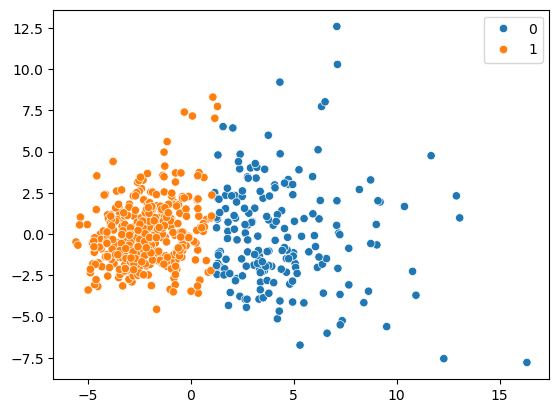

In [9]:
pca = PCA(n_components=2)
if X.shape[1] > 2:
    embed_X = pca.fit_transform(X)
else:
    embed_X = X
    
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)
plt.show()

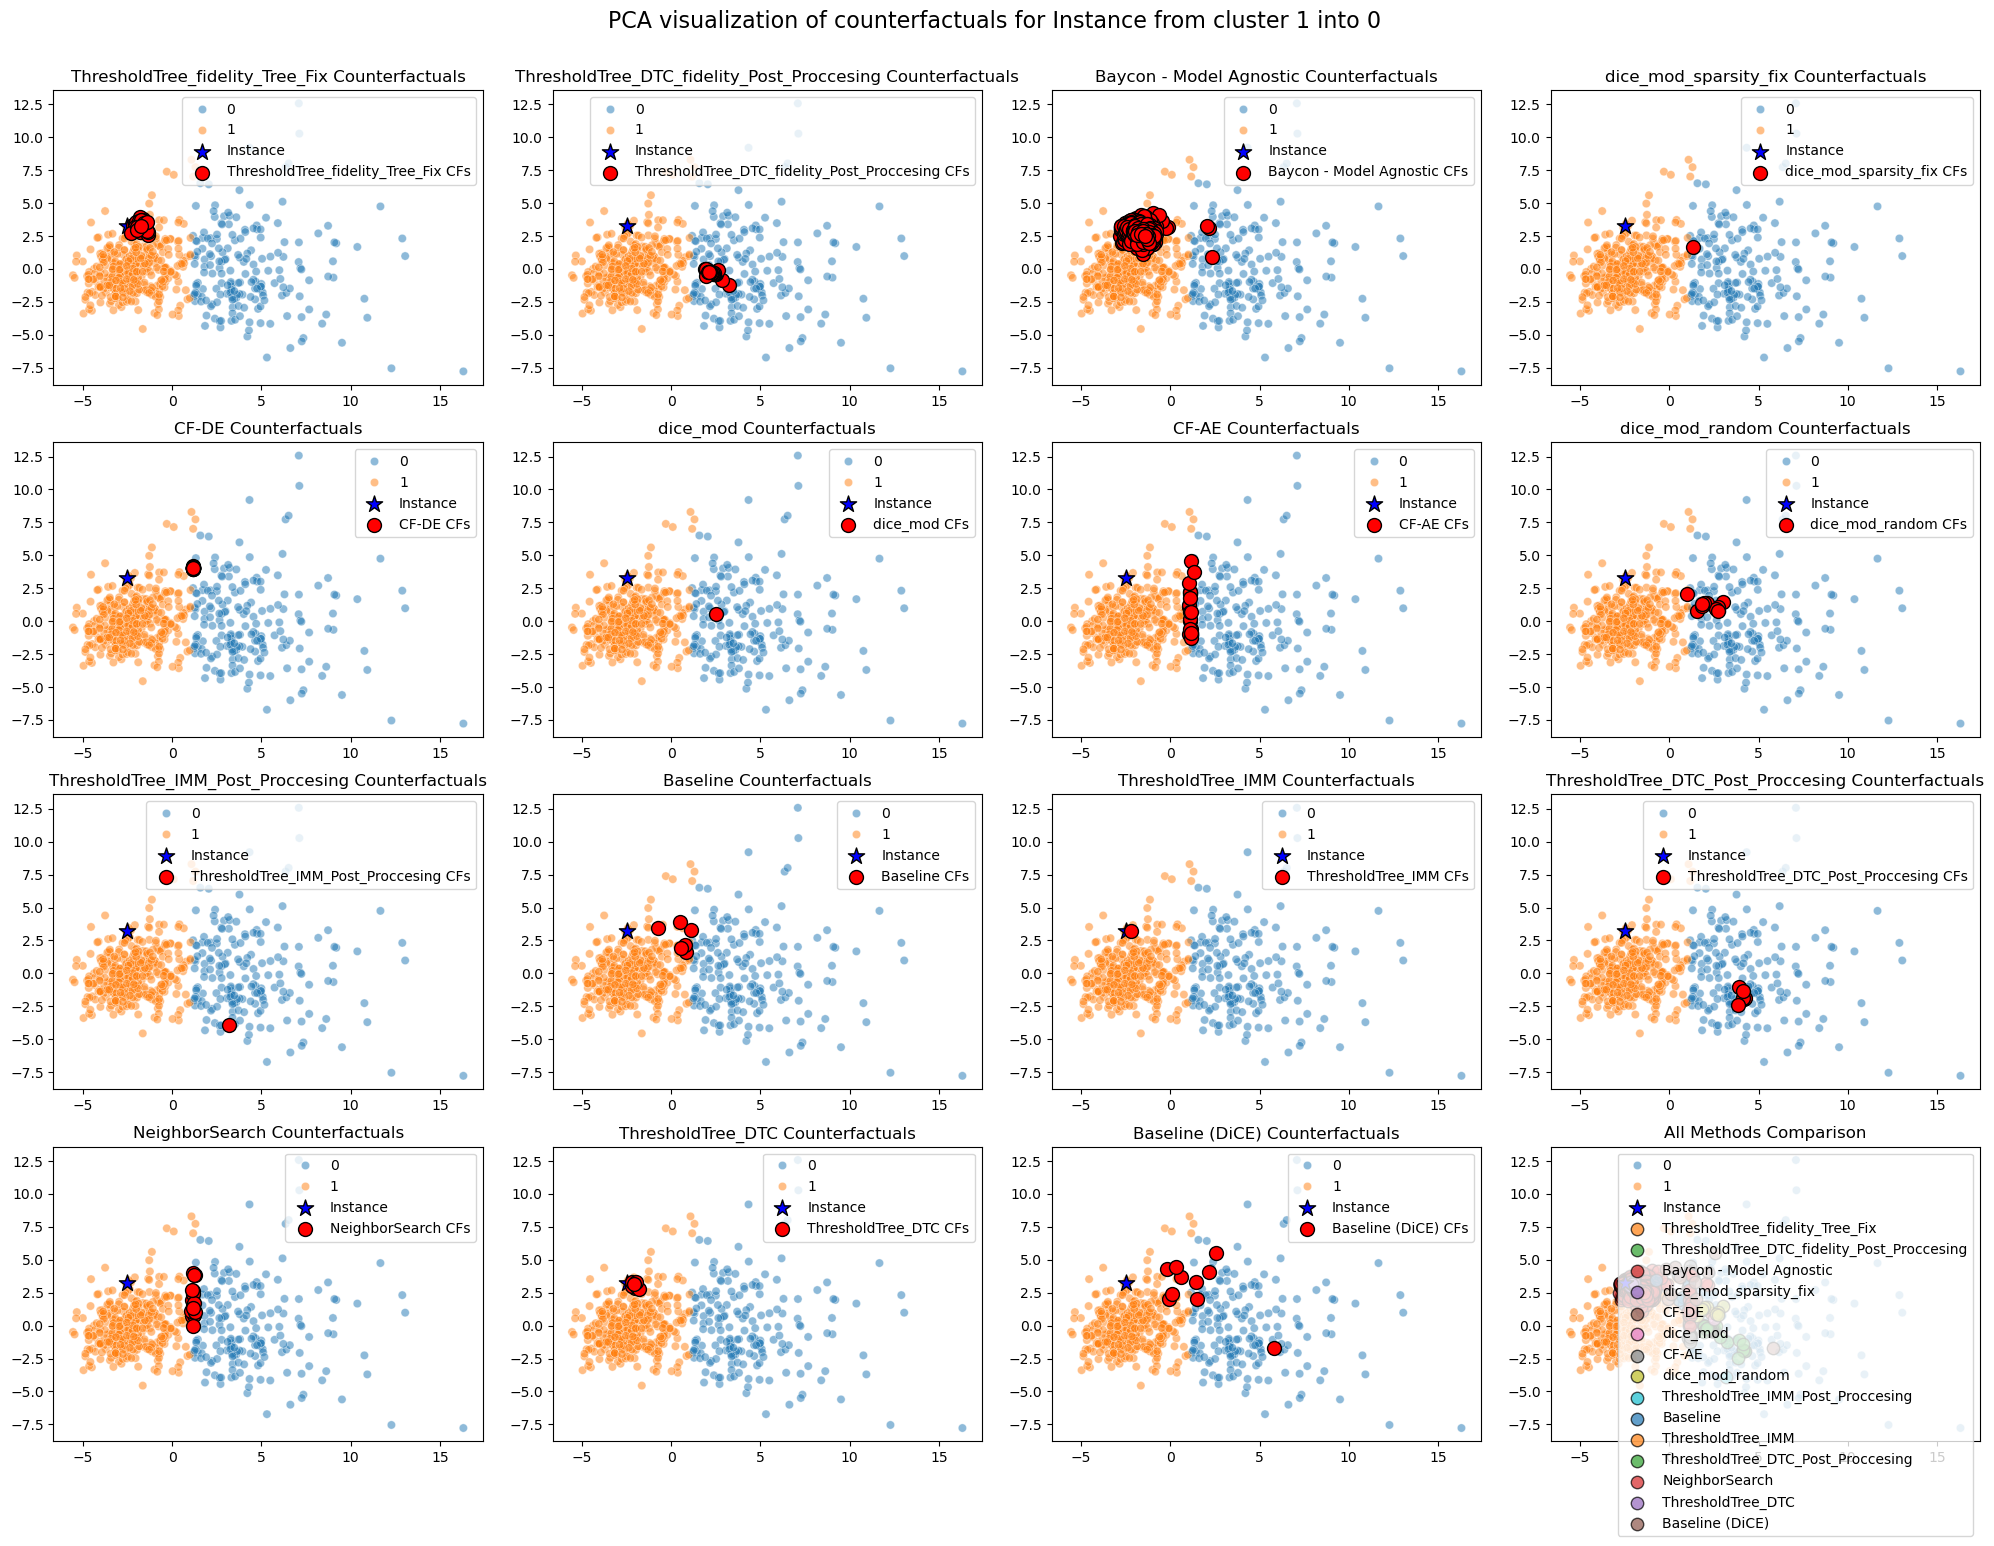

In [10]:
cf_n = 0

# Calculate the number of methods to determine grid size
n_methods = len(methods)
# Create a square-ish grid with enough cells for all methods plus one for comparison
rows = int(np.ceil(np.sqrt((n_methods + 1) / 1.5)))
cols = int(np.ceil((n_methods + 1) / rows))
fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axs = axs.flatten()

cffDict = methods

ins_c = cffDict[0]['counterfactuals'][cf_n].instance_label
target_c = cffDict[0]['counterfactuals'][cf_n].target

if X.shape[1] > 2:
    instance_embedded = pca.transform(X[[cffDict[0]['counterfactuals'][cf_n].instance]])
    methods_embedded = [
        (m['name'], pca.transform(m['counterfactuals'][cf_n].cf)) 
        for m in methods
    ]
else:
    instance_embedded = X[[cffDict[0]['counterfactuals'][cf_n].instance]]
    methods_embedded = [
        (m['name'], np.array(m['counterfactuals'][cf_n].cf)) 
        for m in methods
    ]

# Base scatterplot of the data
for i in range(len(methods_embedded)):
    sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y, alpha=0.5, ax=axs[i])
    axs[i].scatter(instance_embedded[:, 0], instance_embedded[:, 1], color='blue', s=150, 
                  marker='*', label='Instance', zorder=5, edgecolor='black')

for i, (name, embed) in enumerate(methods_embedded):
    axs[i].scatter(embed[:, 0], embed[:, 1], color='red', s=100, 
                 marker='o', label=f'{name} CFs', zorder=5, edgecolor='black')
    axs[i].set_title(f"{name} Counterfactuals")
    axs[i].legend(loc='upper right')

# Add a global title
fig.suptitle(f"PCA visualization of counterfactuals for Instance from cluster {ins_c} into {int(target_c)}", 
            fontsize=16, y=0.98)

# Final subplot for combined view
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y, alpha=0.5, ax=axs[len(methods_embedded)])
axs[len(methods_embedded)].scatter(instance_embedded[:, 0], instance_embedded[:, 1], color='blue', s=150, 
              marker='*', label='Instance', zorder=5, edgecolor='black')

# Add all counterfactuals with different markers
for i, (name, embed) in enumerate(methods_embedded):
    axs[len(methods_embedded)].scatter(embed[:, 0], embed[:, 1], label=name, s=80, 
                 alpha=0.7, edgecolor='black')
axs[len(methods_embedded)].set_title("All Methods Comparison")
axs[len(methods_embedded)].legend(loc='upper right')

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()